### Objective
The objective of this python notebook is to use LSTM to predict monthly crude palm oil prices.



#### Data
The dataset is available at the following links:https://www.indexmundi.com/commodities/?commodity=palm-oil&months=300.

#### Mount Google Drive to Google Colab Notebook

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


#### Use pip to install required packages: sklearn

In [2]:
!pip install sklearn

#### Import the required libraries

In [170]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
from pandas import read_csv
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

#### Load the dataset using the following code:

In [214]:
data = pd.read_csv("/content/gdrive/MyDrive/Univariate Crude Palm Oil Price Prediction/Data/crude_palmoil_price.csv")

In [149]:
data.head()

,Month,cpo_pri
0,1990-05,281
1,1990-06,272
2,1990-07,279
3,1990-08,291
4,1990-09,284


#### Pull out the time-series

In [215]:
data_ts = data['cpo_pri']

#### Plot the crude palm oil data


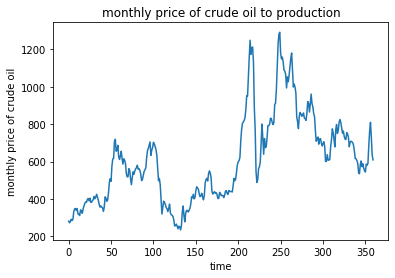

In [216]:
data = data.iloc[:,1].values
plt.plot(data)
plt.xlabel('time')
plt.ylabel('monthly price of crude oil')
plt.title('monthly price of crude oil to production')
plt.show()

#### Data preprocessing

In [217]:
data = data.reshape(-1,1)
data = data.astype('float32')
data.shape

(360, 1)

#### Normalize the dataset

In [218]:
scaler = MinMaxScaler(feature_range=(0,1))
data = scaler.fit_transform(data)

#### Split the dataset into test and train sets.

In [219]:
train_size = int(len(data)*0.67)
test_size = len(data) - train_size
train = data[0:train_size,:]
test = data[train_size:len(data),:]
print('train_size : {}, test_size : {}'.format(len(train),len(test)))

train_size : 241, test_size : 119


#### Set the number of past timesteps that are needed to learn or predict the next timestep:


In [220]:
timestamp=10
dataX = []
dataY = []
for i in range(len(train)-timestamp-1):
    a = train[i:(i+timestamp),0]
    dataX.append(a)
    dataY.append(train[i+timestamp,0])
trainX = np.array(dataX)
trainY = np.array(dataY)

In [221]:
timestep=10
dataX = []
dataY = []
for i in range(len(test)-timestamp-1):
    a = test[i:(i+timestamp),0]
    dataX.append(a)
    dataY.append(test[i+timestamp,0])
testX = np.array(dataX)
testY = np.array(dataY)

In [222]:
trainX = np.reshape(trainX,(trainX.shape[0],1,trainX.shape[1]))
testX = np.reshape(testX,(testX.shape[0],1,testX.shape[1]))

#### Build, compile and train the LSTM model:

In [223]:
from tensorflow import keras
model = Sequential()
model.add(LSTM(10, input_shape=(1, timestamp)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=50, batch_size=1)

Epoch 1/50
230/230 [==============================] - 2s 2ms/step - loss: 0.0208
Epoch 2/50
230/230 [==============================] - 0s 1ms/step - loss: 0.0095
Epoch 3/50
230/230 [==============================] - 0s 1ms/step - loss: 0.0075
Epoch 4/50
230/230 [==============================] - 0s 1ms/step - loss: 0.0059
Epoch 5/50
230/230 [==============================] - 0s 1ms/step - loss: 0.0047
Epoch 6/50
230/230 [==============================] - 0s 1ms/step - loss: 0.0041
Epoch 7/50
230/230 [==============================] - 0s 1ms/step - loss: 0.0034
Epoch 8/50
230/230 [==============================] - 0s 1ms/step - loss: 0.0029
Epoch 9/50
230/230 [==============================] - 0s 2ms/step - loss: 0.0028
Epoch 10/50
230/230 [==============================] - 0s 1ms/step - loss: 0.0026
Epoch 11/50
230/230 [==============================] - 0s 2ms/step - loss: 0.0022
Epoch 12/50
230/230 [==============================] - 0s 1ms/step - loss: 0.0021
Epoch 13/50
230/230 [====

#### Evaluate the model and print the Mean Square Error (MSE) and the Root Mean Square Error (RMSE):

In [224]:
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 36.04 RMSE
Test Score: 52.47 RMSE


#### Predict the values using the LSTM model and plot them, both for test and train datasets:

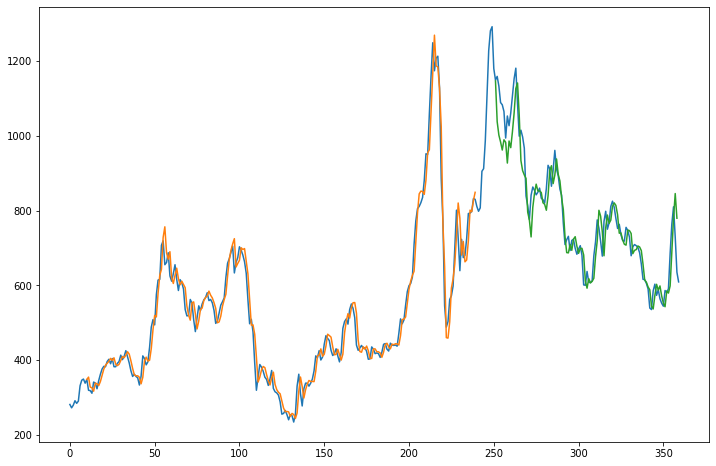

In [225]:
trainPredictPlot = np.empty_like(data)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[timestamp:len(trainPredict)+timestamp, :] = trainPredict

testPredictPlot = np.empty_like(data)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(timestamp*2)+1:len(data)-1, :] = testPredict

plt.figure(figsize=(12, 8))
plt.plot(scaler.inverse_transform(data))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()